In [1]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 获取当前 Notebook 的路径
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 获取上一级目录
parent_dir = os.path.dirname(current_dir)

# 添加上一级目录到 sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import read_jsonl

In [3]:
import os
import time
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from functools import partial
from eap.metrics import logit_diff
from eap.graph import Graph
from eap.dataset import EAPDataset
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline, get_circuit_logits

In [4]:
revised_entity_first_token_accuracy = [
    0.100253066,
    0.104925054,
    0.100253066,
    0.101421063,
    0.102394394,
    0.103173058,
    0.10511972,
    0.104730387,
    0.10609305,
    0.111349036,
    0.126532996,
    0.139380962,
    0.183764843,
    0.24002336,
    0.305625852,
    0.373953669,
    0.430796185,
    0.481798715,
    0.525403932,
    0.570955811,
    0.599182402,
    0.63616897,
    0.665368892,
    0.687171501,
    0.714814094,
    0.725326066,
    0.763675297,
    0.770488612,
    0.785283239,
    0.796768542,
    0.813704497,
    0.813704497,
    0.83122445,
    0.838621764,
    0.848549737,
    0.857893712,
    0.867237687,
    0.863344364,
    0.882226981,
    0.890402959,
    0.885341639,
    0.886898968,
    0.885925638,
    0.887288301,
    0.892933619,
    0.898773603,
    0.897994939,
    0.904808254,
    0.905392252,
    0.91006424,
    0.917850886,
    0.916877555,
    0.92018688,
    0.920770878,
    0.918824216,
    0.91862955,
    0.917461553,
    0.918240218,
    0.917072221,
    0.917072221,
    0.915709558,
    0.914930894,
    0.927000195,
    0.92116021,
    0.919602881,
    0.919408215,
    0.924274869,
    0.92018688,
    0.924274869,
    0.927194861,
    0.928557524,
    0.924274869,
    0.926026864,
    0.917461553,
    0.924274869,
    0.927000195,
    0.927194861,
    0.926610862,
    0.924080202,
    0.922328207,
    0.922328207,
    0.926610862,
    0.930114853,
    0.926026864,
    0.927973525,
    0.925248199,
    0.926026864,
    0.92018688,
    0.923496204,
    0.928362858,
    0.92622153,
    0.927778859
]

In [5]:
new_entity_first_token_accuracy = [
    0.101811612,
    0.104692612,
    0.103032375,
    0.102006934,
    0.103764832,
    0.102837053,
    0.104301968,
    0.104643781,
    0.107475951,
    0.108745544,
    0.108696714,
    0.114263392,
    0.12080668,
    0.138678646,
    0.162507935,
    0.19273402,
    0.221055716,
    0.255285903,
    0.295522242,
    0.335123785,
    0.382635871,
    0.407539431,
    0.452268177,
    0.494262415,
    0.517994043,
    0.539625958,
    0.592900044,
    0.618877875,
    0.64617413,
    0.667903706,
    0.695590605,
    0.713853215,
    0.733776063,
    0.748425216,
    0.765320572,
    0.771033742,
    0.779676742,
    0.790077641,
    0.797597539,
    0.816397285,
    0.822354607,
    0.827237658,
    0.832120709,
    0.835294692,
    0.844377167,
    0.854778065,
    0.861321354,
    0.868059964,
    0.874212608,
    0.866546218,
    0.884125201,
    0.887592168,
    0.89545388,
    0.897211778,
    0.897993066,
    0.901704185,
    0.901801846,
    0.900434592,
    0.903755066,
    0.903510914,
    0.906684897,
    0.904878168,
    0.912349236,
    0.911519117,
    0.912446897,
    0.915572049,
    0.9204551,
    0.917671761,
    0.916060355,
    0.922505982,
    0.922798965,
    0.921285219,
    0.920552761,
    0.917232287,
    0.921187558,
    0.917964744,
    0.917720592,
    0.92133405,
    0.918306558,
    0.923091948,
    0.921480541,
    0.924703355,
    0.924849846,
    0.922505982,
    0.925826456,
    0.925289321,
    0.923433761,
    0.919624982,
    0.922457151,
    0.924849846,
    0.925142829,
    0.923580253
]

In [6]:
x_coords = np.arange(len(new_entity_first_token_accuracy)) / (len(new_entity_first_token_accuracy) - 1) * 6

In [7]:
directory_path="../outputs/train/phi-1_5/2025-02-06-00-04-57/checkpoints"
subdirectories = [
    name for name in os.listdir(directory_path)
    if os.path.isdir(os.path.join(directory_path, name))
]

In [8]:
new_entity_result_matrix = []
revised_entity_result_matrix = []
to_delete = []
for dir_name in subdirectories:
    prediction_file = os.path.join(directory_path, dir_name, "prediction.jsonl")
    if not os.path.exists(prediction_file):
        print(f"Prediction file not found for directory '{dir_name}'")
        to_delete.append(dir_name)
    else:
        print(f"Reading prediction file for directory '{dir_name}'")
        predictions = read_jsonl(prediction_file)
        N = len(predictions)
        new_entity_num = int(0.5 * N)
        new_entity_result = [pred["correct"] for pred in predictions][:new_entity_num]
        new_entity_result_matrix.append(new_entity_result)
        revised_entity_result = [pred["correct"] for pred in predictions][new_entity_num:]
        revised_entity_result_matrix.append(revised_entity_result)

for dir_name in to_delete:
    subdirectories.remove(dir_name)

Reading prediction file for directory 'checkpoint-3921'
Reading prediction file for directory 'checkpoint-1960'
Reading prediction file for directory 'checkpoint-4571'
Reading prediction file for directory 'checkpoint-1307'
Reading prediction file for directory 'checkpoint-653'
Reading prediction file for directory 'checkpoint-3267'
Reading prediction file for directory 'checkpoint-2614'


In [9]:
indexes = sorted(range(len(subdirectories)), key=lambda i: int(subdirectories[i].split('-')[1]))

print("排序后的下标列表：", indexes)

排序后的下标列表： [4, 3, 1, 6, 5, 0, 2]


In [10]:
new_entity_result_matrix = [new_entity_result_matrix[i] for i in indexes]
new_entity_result_matrix = np.array(new_entity_result_matrix)
revised_entity_result_matrix = [revised_entity_result_matrix[i] for i in indexes]
revised_entity_result_matrix = np.array(revised_entity_result_matrix)

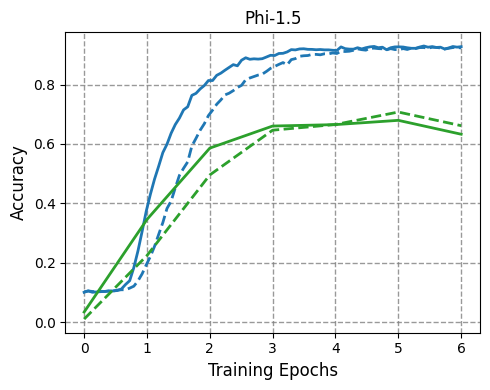

In [11]:
new_entity_accuracy = np.mean(new_entity_result_matrix, axis=1)
revised_entity_accuracy = np.mean(revised_entity_result_matrix, axis=1)

plt.figure(figsize=(5, 4))
plt.plot(x_coords, revised_entity_first_token_accuracy, label='First-token Acc (K_rel)', linewidth=2, color='C0')
plt.plot(x_coords, new_entity_first_token_accuracy, label='First-token Acc (K_compl)', linewidth=2, color='C0', linestyle='--')
plt.plot(revised_entity_accuracy, label='Query Acc (K_rel)', linewidth=2, color='C2')
plt.plot(new_entity_accuracy, label='Query Acc (K_compl)', linewidth=2, color='C2', linestyle='--')

plt.title('Phi-1.5')
plt.xlabel('Training Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

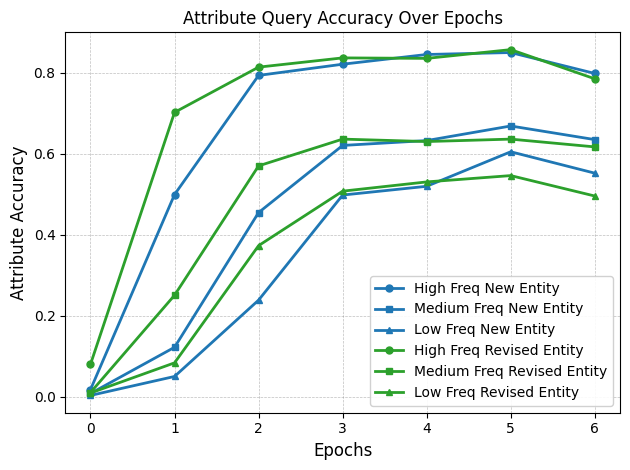

In [12]:
num_columns = new_entity_result_matrix.shape[1]  # 获取列数
num_columns_to_average = num_columns // 3

high_new_entity_accuracy = np.mean(new_entity_result_matrix[:, :num_columns_to_average], axis=1)
high_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, :num_columns_to_average], axis=1)

medium_new_entity_accuracy = np.mean(new_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)
medium_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, num_columns_to_average: 2*num_columns_to_average], axis=1)

low_new_entity_accuracy = np.mean(new_entity_result_matrix[:, -num_columns_to_average:], axis=1)
low_revised_entity_accuracy = np.mean(revised_entity_result_matrix[:, -num_columns_to_average:], axis=1)


plt.plot(high_new_entity_accuracy, label='High Freq New Entity', color='C0', marker='o', linewidth=2, markersize=5)
plt.plot(medium_new_entity_accuracy, label='Medium Freq New Entity', color='C0', marker='s', linewidth=2, markersize=5)
plt.plot(low_new_entity_accuracy, label='Low Freq New Entity', color='C0', marker='^', linewidth=2, markersize=5)

plt.plot(high_revised_entity_accuracy, label='High Freq Revised Entity', color='C2', marker='o', linewidth=2, markersize=5)
plt.plot(medium_revised_entity_accuracy, label='Medium Freq Revised Entity', color='C2', marker='s', linewidth=2, markersize=5)
plt.plot(low_revised_entity_accuracy, label='Low Freq Revised Entity', color='C2', marker='^', linewidth=2, markersize=5)

plt.title('Attribute Query Accuracy Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Attribute Accuracy', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# # Annotate each point with its accuracy value
# for i, accuracy in enumerate(new_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

# for i, accuracy in enumerate(revised_entity_accuracy):
#     plt.text(i, accuracy, f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

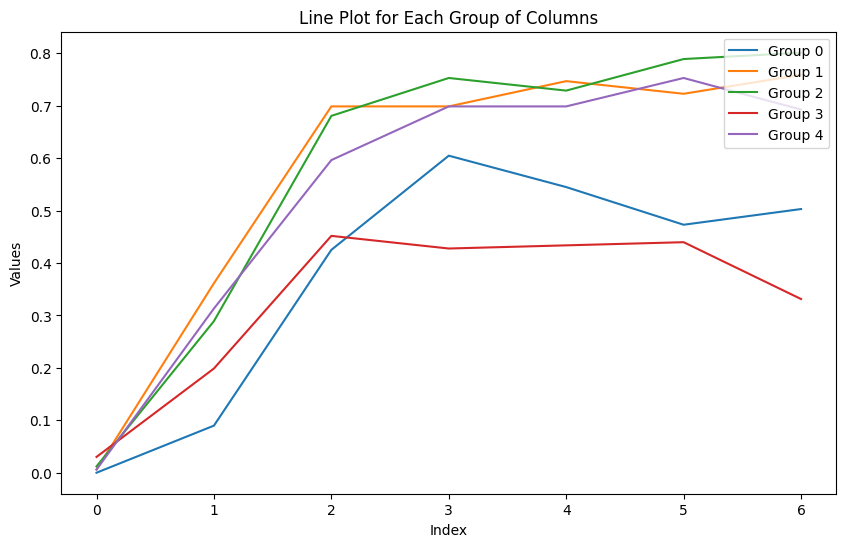

In [13]:
# 拆分矩阵，按第二维除以5的余数进行分组
# 创建5个子矩阵，每个子矩阵包含按除以5余数拆分的行
split_matrices = {i: [] for i in range(5)}

# 遍历矩阵的列，按余数分组
for j in range(revised_entity_result_matrix[:, num_columns_to_average+2:2*num_columns_to_average].shape[1]):
    remainder = j % 5  # 计算列索引除以5的余数
    split_matrices[remainder].append(revised_entity_result_matrix[:, num_columns_to_average+2:2*num_columns_to_average][:, j])

# 绘制每个拆分后的子矩阵的折线图
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(np.mean(split_matrices[i], axis=0), label=f'Group {i}')

plt.title('Line Plot for Each Group of Columns')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend(loc='upper right')
plt.show()

In [14]:
def reduce_array(arr, n):
    """
    将有序数组的元素减少到 n 个，均匀删减元素。

    参数:
    - arr: 原始有序数组
    - n: 缩减后的元素数量

    返回:
    - 新的缩减后数组
    """
    N = len(arr)
    if n >= N:
        return arr  # 如果需要的元素数量大于或等于原数组数量，则返回原数组

    # 计算步长 step，确保均匀删减
    step = N / n

    # 保留均匀分布的 n 个元素
    reduced_arr = [arr[int(i * step)] for i in range(n)]

    return reduced_arr

In [15]:
n = 1000
ensembeld_new_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in new_entity_result_matrix]
ensembeld_new_entity_result_matrix = np.array(ensembeld_new_entity_result_matrix)
ensembeld_new_entity_result_matrix.shape

(7, 200)

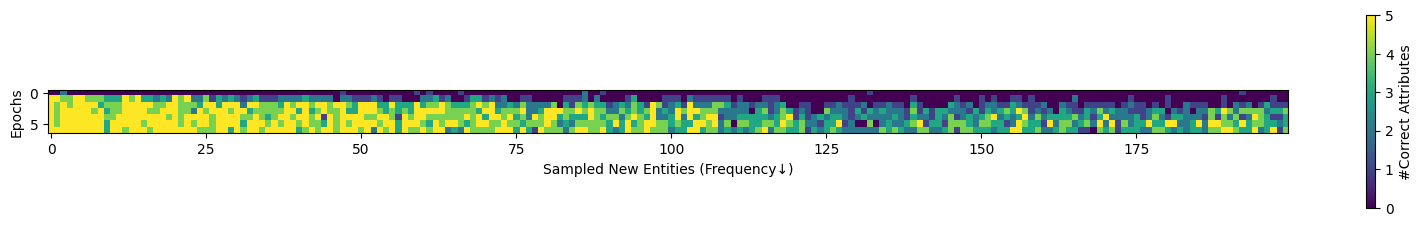

In [16]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_new_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled New Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [17]:
ensembeld_revised_entity_result_matrix = [[sum(reduce_array(line, n)[i:i + 5]) for i in range(0, n, 5)] for line in revised_entity_result_matrix]
ensembeld_revised_entity_result_matrix = np.array(ensembeld_revised_entity_result_matrix)
ensembeld_revised_entity_result_matrix.shape

(7, 200)

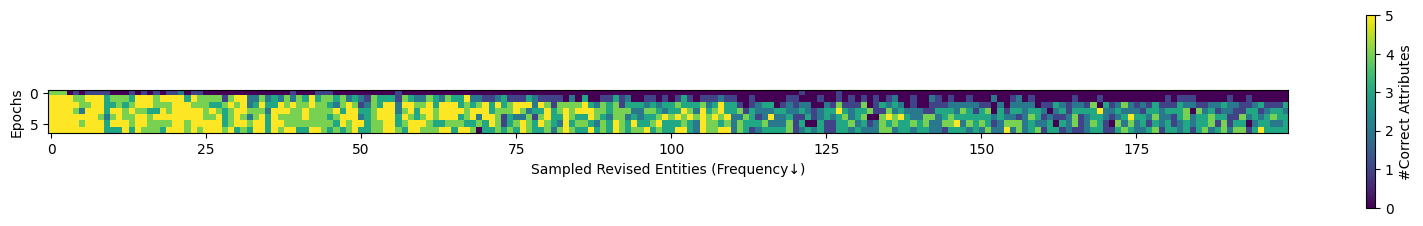

In [18]:
plt.figure(figsize=(20, 2.5))  # 调整宽度和高度
plt.imshow(ensembeld_revised_entity_result_matrix, cmap='viridis', interpolation='nearest')
plt.ylabel('Epochs')
plt.xlabel('Sampled Revised Entities (Frequency↓)')
plt.colorbar().set_label('#Correct Attributes')
plt.show()

In [19]:
hit_at_10_results = {
    "new": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    },
    "revised": {
        "high": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "medium": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        },
        "low": {
            "new": {
                "high": [],
                "medium": [],
                "low": []
            },
            "revised": {
                "high": [],
                "medium": [],
                "low": []
            }
        }
    }
}

k_type = {
    "new": "K_compl",
    "revised": "K_rel"
}

topn = 50000
circuit_n = 300
for task in ["city"]:
    for index in tqdm(indexes):
        for source_type in ["new", "revised"]:
            for source_frequency in ["high", "medium", "low"]:
                target_type = source_type
                target_frequency = source_frequency
                # for target_type in ["new", "revised"]:
                #     for target_frequency in ["high", "medium", "low"]:
                result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{source_type}", f"frequency_{source_frequency}", "method_EAP-IG", f"topn_{topn}", f"target_type_{target_type}", f"target_frequency_{target_frequency}", f"{task}_prediction.jsonl")
                results = read_jsonl(result_file)
                hit_at_10 = len([d for d in results if d["token_rank"] <= 9]) / len(results)
                hit_at_10_results[source_type][source_frequency][target_type][target_frequency].append(hit_at_10)

100%|██████████| 7/7 [00:00<00:00, 125.98it/s]


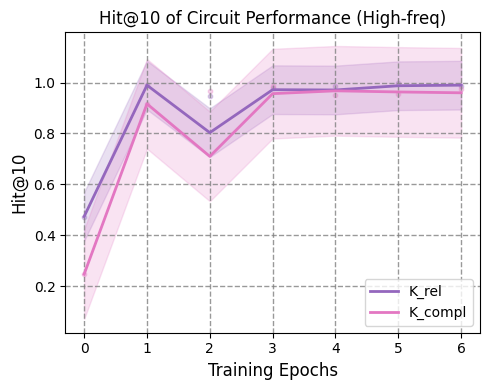

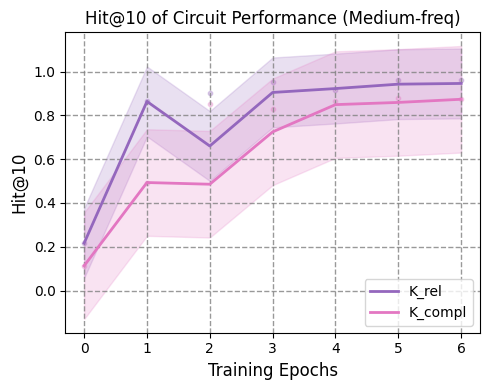

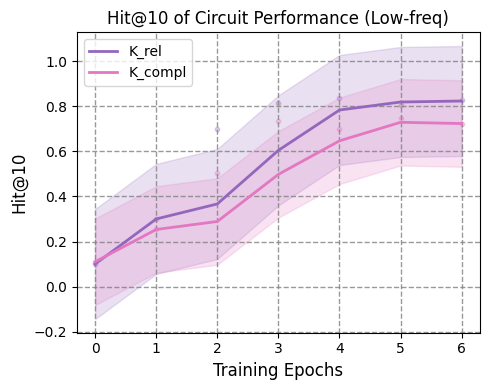

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_frequency in ["high", "medium", "low"]:
    plt.figure(figsize=(5, 4))
    color_cnt = 4
    for source_type in ["revised", "new"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]
        
        # # 定义核函数
        # kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1))

        # # 拟合高斯过程回归模型
        # gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        # gp.fit(x[:, np.newaxis], y)

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)[:, np.newaxis]
        # y_fit, std_residuals = gp.predict(x_fit, return_std=True)

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)
        
        line, = plt.plot(x_fit.ravel(), y_fit, label=f'{k_type[source_type].capitalize()}', linewidth=2, color=f'C{color_cnt}')
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit.ravel(), y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)
        
        color_cnt += 2

    plt.title(f'Hit@10 of Circuit Performance ({source_frequency.capitalize()}-freq)', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

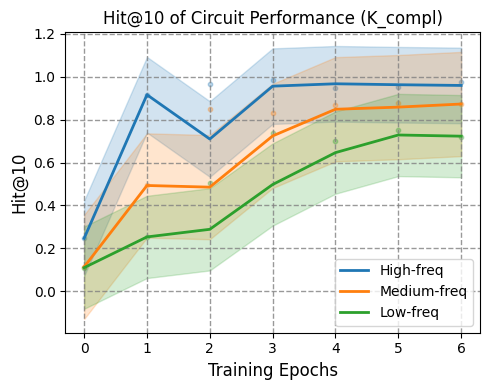

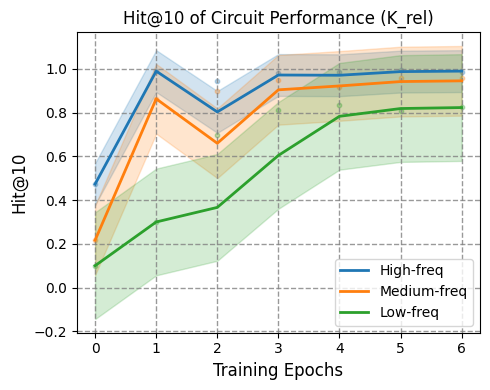

In [21]:
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(len(indexes))
for source_type in ["new", "revised"]:
    plt.figure(figsize=(5, 4))
    for source_frequency in ["high", "medium", "low"]:
        y = [0 for _ in range(len(indexes))]
        cnt = 0
        target_type = source_type
        target_frequency = source_frequency
        for i, hit_at_10 in enumerate(hit_at_10_results[source_type][source_frequency][target_type][target_frequency]):
            y[i] += hit_at_10
        cnt += 1
        # y += hit_at_10_results[source_type][source_frequency][target_type][target_frequency]

        y = [v / cnt for v in y]

        # # 使用样条插值
        # spline = UnivariateSpline(x, y, s=1)  # s 控制平滑程度，越大越平滑

        # # 生成拟合曲线的 y 值
        # x_fit = np.linspace(0, len(indexes), 50)
        # y_fit = spline(x_fit)

        # # 计算残差并估算标准差
        # y_residuals = y - spline(x)
        # std_residuals = np.std(y_residuals)
        
        window_size = 3
        x_fit = x
        y_fit = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
        y_fit = np.array(y[:window_size-1] + y_fit.tolist())
        y_residuals = y - y_fit
        std_residuals = np.std(y_residuals)

        line, = plt.plot(x_fit, y_fit, label=f'{source_frequency.capitalize()}-freq', linewidth=2)
        plt.scatter(x, y, color=line.get_color(), s=10, alpha=0.3)
        
        # 绘制阴影区域，偏离值区域
        plt.fill_between(x_fit, y_fit - 1.96 * std_residuals, y_fit + 1.96 * std_residuals, color=line.get_color(), alpha=0.2)

    plt.title(f'Hit@10 of Circuit Performance ({k_type[source_type]})', fontsize=12)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Hit@10', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [22]:
from collections import defaultdict

def create_performance_dict():
    return defaultdict(lambda: {"new": create_freq_dict(), "revised": create_freq_dict()})

def create_freq_dict():
    # 使用 lambda 递归创建嵌套字典结构
    return {"high": [], "medium": [], "low": []}

# 使用函数创建相同结构的嵌套字典
faithfulness_performance = create_performance_dict()
edge_entropy = create_performance_dict()
graph = create_performance_dict()

for index in tqdm(indexes):
    for task in ["city"]:
        for type in ["new", "revised"]:
            for freq in ["high", "medium", "low"]:
                result_file = os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_results.json")
                results = json.load(open(result_file))
                faithfulness_performance[task][type][freq].append(results["faithfulness"])
                edge_entropy[task][type][freq].append(results["edge_entropy"])
                g = Graph.from_pt(os.path.join(directory_path, subdirectories[index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"{task}_graph.pt"))
                g.reset_nodes_and_edges()
                g.apply_topn(topn, absolute=True)
                g.prune_dead_nodes()
                graph[task][type][freq].append(g)

100%|██████████| 7/7 [46:19<00:00, 397.12s/it]


In [23]:
def jaccard_similarity(a, b):
    """
    计算两个集合的 Jaccard 相似度。

    参数:
    - a: 集合 a
    - b: 集合 b

    返回:
    - Jaccard 相似度
    """
    set_a = set()
    for key, value in a.items():
        if value.in_graph:
             set_a.add(key)
    set_b = set()
    for key, value in b.items():
        if value.in_graph:
             set_b.add(key)
    return len(set_a & set_b) / len(set_a | set_b)

In [24]:
nodes_last_jaccard_similarity = create_performance_dict()
edges_last_jaccard_similarity = create_performance_dict()

for task in ["city"]:
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(1, len(indexes)):
                nodes_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].nodes, graph[task][type][freq][-1].nodes))
                edges_last_jaccard_similarity[task][type][freq].append(jaccard_similarity(graph[task][type][freq][i-1].edges, graph[task][type][freq][-1].edges))

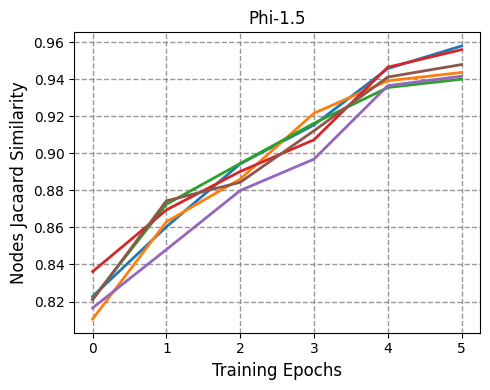

In [25]:
# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(nodes_last_jaccard_similarity[task]["new"]["high"]))  # Adjust if necessary

for task in ["city"]:
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5, 4))  # Adjust width and height as needed
    cnt = 0
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            plt.plot(epochs, nodes_last_jaccard_similarity[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
            cnt += 1

    # Set titles and labels
    plt.title(f'Phi-1.5')
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Nodes Jacaard Similarity', fontsize=12)
    # plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

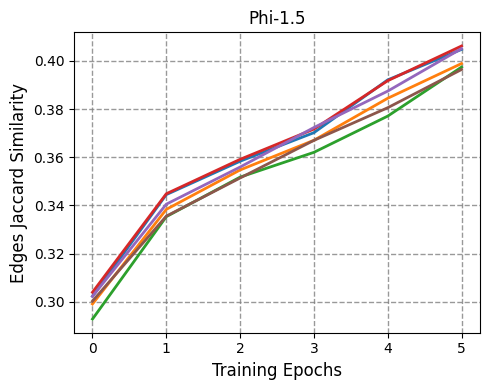

In [34]:
# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(edges_last_jaccard_similarity[task]["new"]["high"]))  # Adjust if necessary

for task in ["city"]:
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5, 4))  # Adjust width and height as needed
    cnt = 0
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            plt.plot(epochs, edges_last_jaccard_similarity[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
            cnt += 1

    # Set titles and labels
    plt.title(f'Phi-1.5')
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Edges Jaccard Similarity', fontsize=12)
    # plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

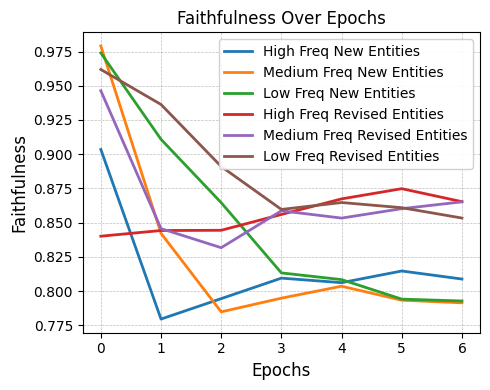

In [27]:
task = "city"

# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(faithfulness_performance[task]["new"]["high"]))  # Adjust if necessary

cnt = 0
for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        plt.plot(epochs, faithfulness_performance[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
        cnt += 1

# Set titles and labels
plt.title(f'Faithfulness Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Faithfulness', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [32]:
import math

def calculate_entropy(g):
    # 获取所有边的 score 绝对值
    scores = [abs(edge.score) for edge in g.edges.values()]
    
    # 如果没有有效的 score 值，返回 None
    if not scores:
        return None
    
    # 归一化 score 值以生成概率分布
    total_score = sum(scores)
    probabilities = [score / total_score for score in scores]

    # 根据 Shannon 公式计算熵
    edge_entropy = -sum(p * math.log(p) for p in probabilities if p > 0)
    
    return edge_entropy

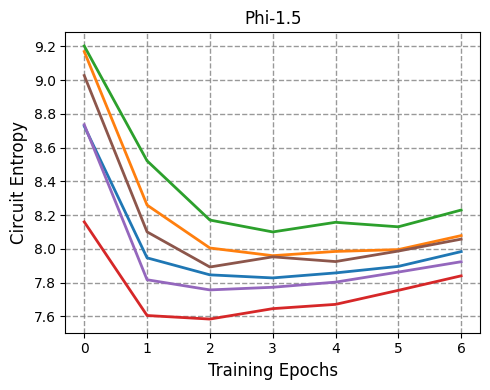

In [31]:
# Assuming `epochs` is the x-axis variable that defines the number of epochs
epochs = np.arange(len(edge_entropy["city"]["new"]["high"]))  # Adjust if necessary

for task in ["city"]:
    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5, 4))  # Adjust width and height as needed
    
    cnt = 0
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            plt.plot(epochs, edge_entropy[task][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
            cnt += 1

    # Set titles and labels
    plt.title(f'Phi-1.5')
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Circuit Entropy', fontsize=12)
    # plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()